In [1]:
# utilities
import re
import numpy as np
import pandas as pd
import re
import string
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import ticker
import plotly.express as px

# nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [3]:
# upload file to google colab notebook 
from google.colab import files
  
  
uploaded = files.upload()

Saving vaccination_all_tweets.csv to vaccination_all_tweets.csv


In [4]:
# import pandas as pd
# import io
# tweets_df = pd.read_csv('/vaccination_all_tweets.csv')
# tweets_df.dtypes

In [6]:
# load dataset into google colab
import pandas as pd
import io
tweets_df = pd.read_csv(io.BytesIO(uploaded['vaccination_all_tweets.csv']))
tweets_df.dtypes

id                   int64
user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
retweets             int64
favorites            int64
is_retweet            bool
dtype: object

# 1. Loading and cleaning data

In [7]:
tweets_df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [8]:
# shape of data
tweets_df.shape

(228207, 16)

In [11]:
# selecting data required for NLP
col = ['user_name', 'date', 'text']
tweets_df = tweets_df[col]
tweets_df.head()

,user_name,date,text
0,Rachel Roh,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...
1,Albert Fong,2020-12-13 16:27:13,While the world has been on the wrong side of ...
2,eli🇱🇹🇪🇺👌,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,Charles Adler,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're..."
4,Citizen News Channel,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...


In [12]:
# check datatypes
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228207 entries, 0 to 228206
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_name  228205 non-null  object
 1   date       228207 non-null  object
 2   text       228207 non-null  object
dtypes: object(3)
memory usage: 5.2+ MB


In [13]:
# change datatype for username
tweets_df.user_name = tweets_df.user_name.astype('category')
tweets_df.user_name = tweets_df.user_name.cat.codes

#  day, month, and year of the tweet
tweets_df.date = pd.to_datetime(tweets_df.date).dt.date
tweets_df.head()

,user_name,date,text
0,52790,2020-12-20,Same folks said daikon paste could treat a cyt...
1,3603,2020-12-13,While the world has been on the wrong side of ...
2,74633,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,12945,2020-12-12,"Facts are immutable, Senator, even when you're..."
4,14095,2020-12-12,Explain to me again why we need a vaccine @Bor...


In [14]:
# check datatypes
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228207 entries, 0 to 228206
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_name  228207 non-null  int32 
 1   date       228207 non-null  object
 2   text       228207 non-null  object
dtypes: int32(1), object(2)
memory usage: 4.4+ MB


# 2. Processing the data

In [15]:
# 1. select the text column of our dataset
texts_df=tweets_df['text']
texts_df

0         Same folks said daikon paste could treat a cyt...
1         While the world has been on the wrong side of ...
2         #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3         Facts are immutable, Senator, even when you're...
4         Explain to me again why we need a vaccine @Bor...
                                ...                        
228202    45+ #URBAN #Bengaluru #CovidVaccine Availabili...
228203    18-44 #BBMP #Bengaluru #CovidVaccine Availabil...
228204    18-44 #URBAN #Bengaluru #CovidVaccine Availabi...
228205    They promote their Vaccines leaving out the st...
228206    45+ #URBAN #Bengaluru #CovidVaccine Availabili...
Name: text, Length: 228207, dtype: object

In [16]:
# 2. removing the url from all the tweets

remove_url = lambda x: re.sub(r'https\S+', '', str(x))
texts_nourl = texts_df.apply(remove_url)
texts_nourl.head()

0    Same folks said daikon paste could treat a cyt...
1    While the world has been on the wrong side of ...
2    #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3    Facts are immutable, Senator, even when you're...
4    Explain to me again why we need a vaccine @Bor...
Name: text, dtype: object

In [17]:
# 2.1 convert text to lower case

to_lower = lambda x : x.lower()
tweets_lc = texts_nourl.apply(to_lower)
tweets_lc.head()

0    same folks said daikon paste could treat a cyt...
1    while the world has been on the wrong side of ...
2    #coronavirus #sputnikv #astrazeneca #pfizerbio...
3    facts are immutable, senator, even when you're...
4    explain to me again why we need a vaccine @bor...
Name: text, dtype: object

In [18]:
# 2.2 remove all punctuations

remove_pcs = lambda x : x.translate(str.maketrans('', '', string.punctuation))
tweets_pcs = tweets_lc.apply(remove_pcs)
tweets_pcs


0         same folks said daikon paste could treat a cyt...
1         while the world has been on the wrong side of ...
2         coronavirus sputnikv astrazeneca pfizerbiontec...
3         facts are immutable senator even when youre no...
4         explain to me again why we need a vaccine bori...
                                ...                        
228202    45 urban bengaluru covidvaccine availability f...
228203    1844 bbmp bengaluru covidvaccine availability ...
228204    1844 urban bengaluru covidvaccine availability...
228205    they promote their vaccines leaving out the st...
228206    45 urban bengaluru covidvaccine availability f...
Name: text, Length: 228207, dtype: object

In [19]:
# 2.3 remove stop text from the data

# update_words = ['covid','#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19']
stop_words = set(stopwords.words('english'))
# stop_words.update(update_words)

remove_words = lambda x : ' '.join([word for word in x.split() if word not in stop_words])
clean_tweets = tweets_pcs.apply(remove_words)
clean_tweets.head()

0    folks said daikon paste could treat cytokine s...
1    world wrong side history year hopefully bigges...
2    coronavirus sputnikv astrazeneca pfizerbiontec...
3    facts immutable senator even youre ethically s...
4    explain need vaccine borisjohnson matthancock ...
Name: text, dtype: object

In [20]:
# 2 find most common words in tweets
import collections
word_list = [word for line in clean_tweets for word in line.split()]
word_list[:10]

['folks',
 'said',
 'daikon',
 'paste',
 'could',
 'treat',
 'cytokine',
 'storm',
 'pfizerbiontech',
 'world']

In [21]:
# 3 plot most common words in tweets 
import collections
from collections import Counter



word_counts = Counter(word_list).most_common(50)
words_df = pd.DataFrame(word_counts)
words_df.columns = ['word', 'freq']

px.bar(words_df, x='word', y='freq', title='Most Common Words')

# 3 Transform the data

In [22]:
tweets_df.head()

,user_name,date,text
0,52790,2020-12-20,Same folks said daikon paste could treat a cyt...
1,3603,2020-12-13,While the world has been on the wrong side of ...
2,74633,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,12945,2020-12-12,"Facts are immutable, Senator, even when you're..."
4,14095,2020-12-12,Explain to me again why we need a vaccine @Bor...


In [23]:
# join the clean_tweets to main dataframe 
tweets_df.text=clean_tweets
tweets_df.head(5)

,user_name,date,text
0,52790,2020-12-20,folks said daikon paste could treat cytokine s...
1,3603,2020-12-13,world wrong side history year hopefully bigges...
2,74633,2020-12-12,coronavirus sputnikv astrazeneca pfizerbiontec...
3,12945,2020-12-12,facts immutable senator even youre ethically s...
4,14095,2020-12-12,explain need vaccine borisjohnson matthancock ...


In [26]:
# check data type for the dataframe
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228207 entries, 0 to 228206
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_name  228207 non-null  int32         
 1   date       228207 non-null  datetime64[ns]
 2   text       228207 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 4.4+ MB


In [25]:
# convert date to datetime data 
tweets_df['date'] = pd.to_datetime(tweets_df['date'], format='%Y-%m-%d')

tweets_nlp_df = tweets_df.loc[(tweets_df['date'] >= '2021-03-01')]
tweets_nlp_df


,user_name,date,text
11708,9988,2021-03-01,energy sinovac philippinegeneralhospital covid...
11783,64630,2021-03-01,azn times astrazeneca sold stake moderna 1 bil...
11932,48519,2021-03-01,visionary leader leading front proud h’ble pm ...
11933,63956,2021-03-01,appreciable pmmodi taking covaxin 👇 😂
11934,75470,2021-03-01,mugdha46 find slots registering names portal u...
...,...,...,...
228202,69581,2021-11-15,45 urban bengaluru covidvaccine availability 1...
228203,69581,2021-11-15,1844 bbmp bengaluru covidvaccine availability ...
228204,69581,2021-11-15,1844 urban bengaluru covidvaccine availability...
228205,24085,2021-11-15,promote vaccines leaving stronger russia vacci...


# 4 Sentiment Analysis

In [27]:
# use SentimentIntensityAnalyzer, to organize tweets into positive, negetive and neutral category
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
sid = SentimentIntensityAnalyzer()
ps = lambda x : sid.polarity_scores(x)
tweets_scores = tweets_nlp_df.text.apply(ps)
tweets_scores

11708     {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...
11783     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
11932     {'neg': 0.0, 'neu': 0.629, 'pos': 0.371, 'comp...
11933     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
11934     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                                ...                        
228202    {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...
228203    {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...
228204    {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...
228205    {'neg': 0.0, 'neu': 0.49, 'pos': 0.51, 'compou...
228206    {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...
Name: text, Length: 212674, dtype: object

In [28]:
# converting sentiment scores to dataframe
scores_df = pd.DataFrame(data = list(tweets_scores))
scores_df.head()

,neg,neu,pos,compound
0,0.0,0.588,0.412,0.2732
1,0.0,1.000,0.000,0.0000
2,0.0,0.629,0.371,0.7579
3,0.0,1.000,0.000,0.0000
4,0.0,1.000,0.000,0.0000


#### neg	- negative,  neu - neutral, and pos- positive

In [29]:
# using the compund scores labelize the scores: -1<0>1: negative<neutral>positive

# creating score label
score_label = lambda x : 'neutral' if x==0 else('positive' if x>0 else 'negative')

# adding score label to scores dataframe
scores_df['label'] = scores_df.compound.apply(score_label)
scores_df.head()

,neg,neu,pos,compound,label
0,0.0,0.588,0.412,0.2732,positive
1,0.0,1.000,0.000,0.0000,neutral
2,0.0,0.629,0.371,0.7579,positive
3,0.0,1.000,0.000,0.0000,neutral
4,0.0,1.000,0.000,0.0000,neutral


In [30]:
# joining tweets label score to cleaned and formatted tweets_nlp_df
tweets_new_nlp = tweets_nlp_df.join(scores_df.label)
tweets_new_nlp.head()

,user_name,date,text,label
11708,9988,2021-03-01,energy sinovac philippinegeneralhospital covid...,positive
11783,64630,2021-03-01,azn times astrazeneca sold stake moderna 1 bil...,positive
11932,48519,2021-03-01,visionary leader leading front proud h’ble pm ...,neutral
11933,63956,2021-03-01,appreciable pmmodi taking covaxin 👇 😂,negative
11934,75470,2021-03-01,mugdha46 find slots registering names portal u...,positive


In [31]:
# count number of neutral, positive and negative tweets
tweets_count = tweets_new_nlp.label.value_counts().reset_index()
tweets_count

,index,label
0,neutral,98488
1,positive,70593
2,negative,28060


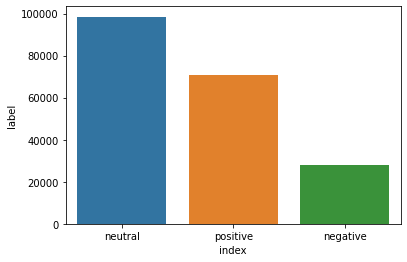

In [32]:
# plotting the count of neutral, positive and negative tweets on barchart
sns.barplot(data=tweets_count, x='index', y='label')

## From the bar chart we can see tweets are generally neutral and positive for the vaccine, to view the tweets sentiments over period of time we need ro chart a line graph


   ##   5     Visualize the tweets sentiments

In [33]:
tweets_new_nlp.head()

,user_name,date,text,label
11708,9988,2021-03-01,energy sinovac philippinegeneralhospital covid...,positive
11783,64630,2021-03-01,azn times astrazeneca sold stake moderna 1 bil...,positive
11932,48519,2021-03-01,visionary leader leading front proud h’ble pm ...,neutral
11933,63956,2021-03-01,appreciable pmmodi taking covaxin 👇 😂,negative
11934,75470,2021-03-01,mugdha46 find slots registering names portal u...,positive


In [34]:
# arranging tweets data by date

tweets_chart = tweets_new_nlp[['user_name', 'date', 'label']].groupby(['date', 'label']).count().reset_index()
tweets_chart.columns = ['date', 'label', 'counts']
tweets_chart.head()

,date,label,counts
0,2021-03-01,negative,578
1,2021-03-01,neutral,1149
2,2021-03-01,positive,1184
3,2021-03-02,negative,168
4,2021-03-02,neutral,354


In [35]:
# charting the sentiment of vaccine overtime

px.line(tweets_chart, x='date', y='counts', color='label', title='Vaccines Sentiment Overtime')
